In [63]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.markers as mks
import numpy as np
import pprint
import random as rn
from itertools import chain
import math
import multiprocessing
import copy
import random

In [64]:
# Parameters for standard configuration
A = 10  # Alpha: maximum number of neighborhoods that a neighborhood can serve
L = 1000  # Lambda: scaling factor for total number of facilities opened
G = 15  # Gamma: penalty for unit unmet demand
k = ["Water", "Food", "Medical Kit", "Shelter"]  # commodities type
# v = dict(zip(k, [1, 1, 0.5, 38500]))  # unit volume of commodity k
cd = dict(zip(k, [2.5, 3, 0.333, 0.2]))  # commodities demand of an injured in 1day
V = 100000 # Volume Capacity of LDC

In [65]:
CMD_Coordinate = [] # [[x1,y1], [x2,y2], ...]
LDC_Coordinate = [] # [[x1,y1], [x2,y2], ...]
EC_Coordinate = [] # [[x1,y1], [x2,y2], ...]
Pop_Blocks = [] # [[x1,y1,pop1], [x2,y2,pop2], ...]
No_CMD = 0 # number of Crises Management Databases
No_LDC = 0 # number of Local Distribution Centers
No_EC = 0 # number of Evacuation Centers
CMD_name = []
LDC_name = []
EC_name = []
c_LDC = [] # capacities of LDC
EC_demand = [] # demands of EC
EC_water_demand = []
EC_food_demand = []
EC_medicalkit_demand = []
EC_shelter_demand = []
elite_Chromosom = []
elites_fitness = math.inf
bad_chromosom_index = 0
genetic_best_solution = np.nan

# Reading the CMD File
def read_CMD_file(path: str):
    global CMD_Coordinate, CMD_name, No_CMD
    with open(path, "r", encoding='utf-8') as file:
        lines = file.readlines()
    for i, line in enumerate(lines, start=1):
        if 1 < i:
            CMD_Attributes = line.split(",")
            CMD_name.append(CMD_Attributes[1])
            CMD_Coordinate.append([float(CMD_Attributes[-2]), float(CMD_Attributes[-1])])
    No_CMD = len(CMD_Coordinate)
    print(f"Number of CMDs: {No_CMD} \nCMD_Name: {CMD_name} \nCMD_Coordinate: {CMD_Coordinate}\n\n")
    file.close()

# Reading the LDC File 
def read_LDC_file(path: str):
    global LDC_Coordinate, LDC_name, No_LDC, c_LDC
    with open(path, "r", encoding='utf-8') as file:
        lines = file.readlines()
    for i, line in enumerate(lines, start=1):
        if 1 < i:
            LDC_Attributes = line.split(",")
            LDC_name.append(LDC_Attributes[5])
            LDC_Coordinate.append([float(LDC_Attributes[-2]), float(LDC_Attributes[-1])])
    No_LDC = len(LDC_Coordinate)
    c_LDC = [V]*No_LDC
    print(f"Number of LDCs: {No_LDC} \nLDC_Name: {LDC_name} \nLDC_Coordinate: {LDC_Coordinate}\n\n")
    file.close()

# Reading the EC File    
def read_EC_file(path: str):
    global EC_Coordinate, EC_name, No_EC
    with open(path, "r", encoding='utf-8') as file:
        lines = file.readlines()
    for i, line in enumerate(lines, start=1):
        if 1 < i:
            EC_Attributes = line.split(",")
            EC_name.append(EC_Attributes[2])
            EC_Coordinate.append([float(EC_Attributes[-2]), float(EC_Attributes[-1])])
    No_EC = len(EC_Coordinate)
    print(f"Number of ECs: {No_EC} \nCE_Name: {EC_name} \nCE_Coordinate: {EC_Coordinate}\n\n")
    file.close()
    
    
def read_Pop_Blocks_file(path: str):
    global Pop_Blocks
    with open(path, "r", encoding='utf-8') as file:
        lines = file.readlines()
    for i, line in enumerate(lines, start=1):
        if 1 < i:
            Pop_Blocks_Attributes = line.split(",")
            Pop_Blocks.append([float(Pop_Blocks_Attributes[-2]), float(Pop_Blocks_Attributes[-1]), float(Pop_Blocks_Attributes[37])])
    No_Pop_Blocks = len(Pop_Blocks)
    print(f"Number of Pop_Blocks: {No_Pop_Blocks}\n Pop_Blocks: {Pop_Blocks}\n\n")
    file.close()

read_CMD_file("C:\\Users\\Amir\\Desktop\\SDSS-Project\\Data\\CMD_Points.txt")
read_LDC_file("C:\\Users\\Amir\\Desktop\\SDSS-Project\\Data\\LDC_Points.txt")
read_EC_file("C:\\Users\\Amir\\Desktop\\SDSS-Project\\Data\\EC_Points.txt")
read_Pop_Blocks_file("C:\\Users\\Amir\\Desktop\\SDSS-Project\\Data\\Reg4PopBlock_Points.txt")

Number of CMDs: 7 
CMD_Name: ['حکیمیه', 'شهید عبادی', 'شهید اشرفی اصفهانی', 'پارک پلیس', 'آب شناسان', 'شهید عراقی', 'شهید بروجردی'] 
CMD_Coordinate: [[553761.069681, 3955093.22817], [549673.546283, 3954136.80222], [549439.228568, 3954121.32858], [548946.167303, 3957481.25995], [547068.365979, 3955672.87226], [541820.6491, 3955714.691], [542276.9608, 3957398.2747]]


Number of LDCs: 97 
LDC_Name: ['پیش دبستان و دبستان نهال دانش', 'مجتمع آموزشی فرهنگ منطقه 4', 'دبیرستان شهید زین الدین', 'دبستان دخترانه فردوس', 'دبیرستان سلام', 'دبستان مهارت آموز', 'مدرسه نشاط', 'مدرسه علمیه حضرت زینب کبری', 'دبستان پسرانه استاد شهريار', 'دبیرستان دوره اول علامه حلی ۲', 'دانشگاه علمی و کاربردی دکتر عبیدی', 'مجتمع آموزشی دخترانه غیردولتی زینبیه', 'دبیرستان دوره اول نمونه دولتی دخترانه سعدی۰', 'هنرستان دخترانه فسایی نژاد', 'مجتمع فرهنگی اسلامی شهدای کشتی\u200cرانی', 'دبیرستان دخترانه فرهیختگان', 'دبستان بادبادک', 'مدرسه غیر انتفاعی دخترانه صبا', 'دبیرستان پسرانه شهید مجمدعلی رجایی', 'دبستان غیردولتی دخترانه

In [66]:
import numpy as np
from scipy.spatial.distance import cdist

Pop_Blocks = np.array(Pop_Blocks)
EC_Coordinate = np.array(EC_Coordinate)
distances = cdist(Pop_Blocks[:, :2], EC_Coordinate, metric='euclidean')

# پیدا کردن اندیس نزدیک‌ترین مرکز برای هر نقطه
assigned_centers = np.argmin(distances, axis=1)
# محاسبه مجموع جمعیت برای هر مرکز
EC_pop = np.bincount(assigned_centers, weights=Pop_Blocks[:, 2])


assignments = {i: [] for i in range(158)}
for point_idx, center_idx in enumerate(assigned_centers):
    assignments[center_idx].append(point_idx)
# چاپ یا ذخیره تخصیص‌ها
# for center_idx, point_indices in assignments.items():
    # print(f"EC {center_idx}: PopBlock {point_indices}")
EC_water_demand = [cd["Water"] * p for p in EC_pop]
EC_food_demand = [cd["Food"] * p for p in EC_pop]
EC_medicalkit_demand = [cd["Medical Kit"] * p for p in EC_pop]
EC_shelter_demand = [cd["Shelter"] * p for p in EC_pop]
EC_demand = [w + f + m + s for w, f, m, s in zip(EC_water_demand, EC_food_demand, EC_medicalkit_demand, EC_shelter_demand)]

print(f"\nwater demand of ECs: {EC_water_demand}\nfood demand of ECs: {EC_food_demand}\nmedicalkit demand of ECs: {EC_medicalkit_demand}\nshelter demand of ECs: {EC_shelter_demand}\n\nvd_EC: {EC_demand}")



water demand of ECs: [20235.0, 2815.0, 59150.0, 28977.5, 45197.5, 21860.0, 225.0, 3515.0, 0.0, 20140.0, 4360.0, 11935.0, 73167.5, 11945.0, 9092.5, 11942.5, 18025.0, 11252.5, 12087.5, 0.0, 2217.5, 1862.5, 28060.0, 3997.5, 5925.0, 6612.5, 2937.5, 6440.0, 1552.5, 20635.0, 2427.5, 10627.5, 11735.0, 4655.0, 935.0, 10327.5, 847.5, 38137.5, 14285.0, 822.5, 6625.0, 25692.5, 10800.0, 55755.0, 15057.5, 16457.5, 24915.0, 3905.0, 2867.5, 25142.5, 7670.0, 4000.0, 8050.0, 12372.5, 18815.0, 4380.0, 2722.5, 955.0, 63670.0, 6615.0, 625.0, 8312.5, 9455.0, 7687.5, 24917.5, 46945.0, 20232.5, 18025.0, 12240.0, 18970.0, 12172.5, 23802.5, 7457.5, 2070.0, 4710.0, 492.5, 11540.0, 35225.0, 5970.0, 17897.5, 12917.5, 38990.0, 1837.5, 28110.0, 4827.5, 17665.0, 12917.5, 13437.5, 6657.5, 19127.5, 16345.0, 30047.5, 20250.0, 3722.5, 8990.0, 7880.0, 15357.5, 17372.5, 13310.0, 12045.0, 5475.0, 2490.0, 58512.5, 13802.5, 3050.0, 27925.0, 14522.5, 31255.0, 19297.5, 2385.0, 5992.5, 4872.5, 15775.0, 27470.0, 22255.0, 6542.5

In [67]:
cmd_ldc_ODMatrix = []
ldc_ec_ODMatrix = []

def CMD_LDC_ODMatrix(path: str):
        global cmd_ldc_ODMatrix, No_CMD, No_LDC
        cmd_ldc_ODMatrix = np.full((No_CMD, No_LDC), np.nan)
        with open(path, "r", encoding='utf-8') as file:
                lines = file.readlines()
        file.close()
        for i, line in enumerate(lines, start=1):
                if 1 < i:
                        Attributes = line.split(",")
                        OriginID = Attributes[2]
                        DestinationID = Attributes[3]
                        cmd_ldc_ODMatrix[int(OriginID)-1][int(DestinationID)-1] = float(Attributes[-1])
CMD_LDC_ODMatrix("C:\\Users\\Amir\\Desktop\\SDSS-Project\\Data\\OD_Matrix(CMDs_to_LDCs).txt")
# pprint.pprint(cmd_ldc_ODMatrix)

def LDC_EC_ODMatrix(path: str):
        global ldc_ec_ODMatrix, No_LDC, No_EC
        ldc_ec_ODMatrix = np.full((No_LDC, No_EC), np.nan)
        with open(path, "r", encoding='utf-8') as file:
                lines = file.readlines()
        file.close()
        for i, line in enumerate(lines, start=1):
                if 1 < i:
                        Attributes = line.split(",")
                        OriginID = Attributes[2]
                        DestinationID = Attributes[3]
                        print(Attributes[1])
                        ldc_ec_ODMatrix[int(OriginID)-1][int(DestinationID)-1] = float(Attributes[-1])
LDC_EC_ODMatrix("C:\\Users\\Amir\\Desktop\\SDSS-Project\\Data\\OD_Matrix(LDCs_to_ECs).txt")
np.set_printoptions(threshold=np.inf)
print(cmd_ldc_ODMatrix)


مدرسه غیر دولتی نیک دخت - بوستان احدزاده
مدرسه غیر دولتی نیک دخت - هنرستان نرگس
مدرسه غیر دولتی نیک دخت - بوستان شبنم
مدرسه غیر دولتی نیک دخت - بوستان اقاقیا
مدرسه غیر دولتی نیک دخت - مدرسه ابو علی سینا
مدرسه غیر دولتی نیک دخت - مدرسه پورداود
مدرسه غیر دولتی نیک دخت - سالن فوتبال مجموعه ورزشی شهید عراقی
مدرسه غیر دولتی نیک دخت - مدرسه استاد خدابخش
مدرسه غیر دولتی نیک دخت - بوستان گلسا
مدرسه غیر دولتی نیک دخت - بوستان 22 بهمن
مدرسه غیر دولتی نیک دخت - مدرسه شهید مفتح
مدرسه غیر دولتی نیک دخت - مدرسه شهید مطهری
مدرسه غیر دولتی نیک دخت - بوستان بهارک
مدرسه غیر دولتی نیک دخت - بوستان ارغوان
مدرسه غیر دولتی نیک دخت - گذر سبز شاهد (غربی)
مدرسه غیر دولتی نیک دخت - بوستان گلبرک
مدرسه غیر دولتی نیک دخت - بوستان فتاحی
مدرسه غیر دولتی نیک دخت - گذر سبز شاهد (شرقی)
مدرسه غیر دولتی نیک دخت - مدرسه تربیت
مدرسه غیر دولتی نیک دخت - بوستان گلنار
مدرسه غیر دولتی نیک دخت - دبیرستان سمیه
مدرسه غیر دولتی نیک دخت - بوستان معین نژاد
مدرسه غیر دولتی نیک دخت - بوستان سمیه
مدرسه غیر دولتی نیک دخت - بوستان نخل
مد

In [68]:
nan_cols_cmd_ldc_ODMatrix = np.where(np.all(np.isnan(cmd_ldc_ODMatrix), axis=0))[0]
# print(f"Nan cols: {nan_cols_cmd_ldc_ODMatrix}")
nan_rows_cmd_ldc_ODMatrix = np.where(np.all(np.isnan(cmd_ldc_ODMatrix), axis=1))[0]
# print(f"Nan rows: {nan_rows_cmd_ldc_ODMatrix}")

nan_cols_ldc_ec_ODMatrix = np.where(np.all(np.isnan(ldc_ec_ODMatrix), axis=0))[0]
# print(f"Nan cols: {nan_cols_ldc_ec_ODMatrix}")
nan_rows_ldc_ec_ODMatrix = np.where(np.all(np.isnan(ldc_ec_ODMatrix), axis=1))[0]
# print(f"Nan rows: {nan_rows_ldc_ec_ODMatrix}")

cmd_invalid_index = list(nan_rows_cmd_ldc_ODMatrix)
ldc_invalid_index = list(nan_rows_ldc_ec_ODMatrix)
ec_invalid_index = list(nan_cols_ldc_ec_ODMatrix)

# No_CMD -= len(cmd_invalid_index)
# No_LDC -= len(ldc_invalid_index)
# No_EC -= len(ec_invalid_index)
# CMD_Coordinate = [i for index, i in enumerate(CMD_Coordinate) if index not in cmd_invalid_index]
# LDC_Coordinate = [i for index, i in enumerate(LDC_Coordinate) if index not in ldc_invalid_index]
# EC_Coordinate = [i for index, i in enumerate(EC_Coordinate) if index not in ec_invalid_index]
# CMD_name = [i for index, i in enumerate(CMD_name) if index not in cmd_invalid_index]
# LDC_name = [i for index, i in enumerate(LDC_name) if index not in ldc_invalid_index]
# EC_name = [i for index, i in enumerate(EC_name) if index not in ec_invalid_index]

print(f"cmd_invalid_index: {cmd_invalid_index}\nldc_invalid_index: {ldc_invalid_index}\nec_invalid_index: {ec_invalid_index}")


cmd_invalid_index: []
ldc_invalid_index: []
ec_invalid_index: [12, 76]


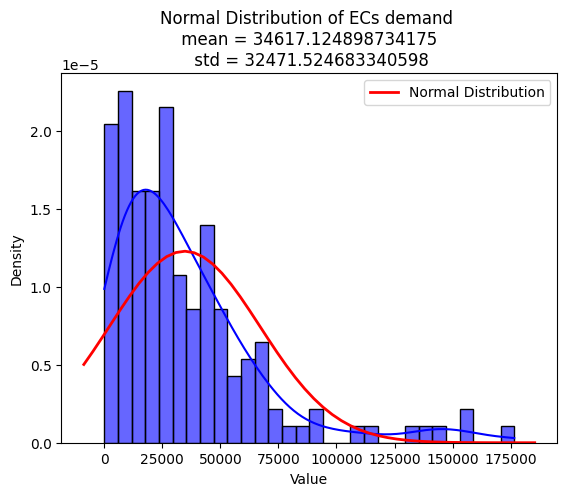

In [69]:
import seaborn as sns
from scipy.stats import norm
mu = 0
std = 0
def df_normalplot(demand_list):
    global mu, std
    sns.histplot(demand_list, bins=30, kde=True, stat="density", color="blue", alpha=0.6)
    # اضافه کردن منحنی تابع توزیع نرمال
    xmin, xmax = plt.xlim()
    mu = np.mean(demand_list)
    std = np.std(demand_list)
    x = np.linspace(xmin, xmax, 50)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'r', linewidth=2, label="Normal Distribution")

    # نمایش نمودار
    plt.legend()
    plt.title(f"Normal Distribution of ECs demand \n mean = {np.mean(demand_list)} \n std = {np.std(demand_list)}")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.show()
        
df_normalplot(EC_demand)


In [70]:
# Initial Population
from scipy.stats import truncnorm
a, b = 0, V
a_std = (a - mu) / std
b_std = (b - mu) / std
# print(random_values)
Population = []
cmd_allowed_numbers = []
ec_allowed_numbers = []
def generate_initial_population(pop_size):
    global Population, No_LDC, No_EC, cmd_invalid_index, ldc_invalid_index, ec_invalid_index, cmd_allowed_numbers, ec_allowed_numbers
    cmd_allowed_numbers = [i for i in range(No_CMD) if i not in cmd_invalid_index]
    ec_allowed_numbers = [i for i in range(No_EC) if i not in ec_invalid_index]
    for ـ in range(pop_size):
        Chromosom_part1 = []
        Chromosom_part2 = []
        # تولید مقدار تصادفی کالا برای هر LDC
        Commo_random_values = truncnorm.rvs(a_std, b_std, loc=mu*2, scale=std, size=No_LDC)
        Commodities_random_values = []
        for crvf in Commodities_random_values:
            Commodities_random_values.append(crvf*cd["Water"] + crvf*cd["Food"] + crvf*cd["Medical Kit"] + crvf*cd["Shelter"])
        Commodities_random_values_filter = [V if crv>V else crv for crv in Commo_random_values]
        for i in range(No_LDC):
            value = rn.randint(0, 1)
            if value == 0 or i in ldc_invalid_index:
                Chromosom_part1.append(0)
            else:
                cmd_rnd = rn.choice(cmd_allowed_numbers)
                commodity_amount = Commodities_random_values_filter[i]
                Chromosom_part1.append([cmd_rnd, commodity_amount])
        Chromosom_part2 = rn.sample(ec_allowed_numbers, len(ec_allowed_numbers))
        Population.append(Chromosom_part1 + Chromosom_part2)
    return Population
# Population = generate_initial_population(100)

In [71]:
#fitness
used_CMD_index = []
opened_LDC_index = []
unmet_demand = np.NaN
additional_inventory = np.NaN
sum_dist = np.NaN
sum_opened_LDC = np.NaN
CMDs_to_LDCs_allocation = {f"{i}":[] for i in range(No_CMD)}
LDCs_to_ECs_dist_allocation = {f"{i}":[] for i in range(No_LDC)}

def fitness(pop):
    global elite_Chromosom, elites_fitness, bad_chromosom_index, unmet_demand, additional_inventory, sum_dist, sum_opened_LDC, sum_EC_notserved, CMDs_to_LDCs_allocation, LDCs_to_ECs_dist_allocation
    fitness_list = []
    for chromosom in pop: 
        CMDs_to_LDCs_allocation = {f"{i}":[] for i in range(No_CMD)}
        LDCs_to_ECs_dist_allocation = {f"{i}":[] for i in range(No_LDC)}
        used_CMD_index = []
        opened_LDC_index = []
        EC_demand_list = [-1]*No_EC
        ecd = []
        used_LDC_inventory_list = []
        CMDs_to_LDCs_dist = []
        LDCs_to_ECs_dist = []
        for index, i in enumerate(chromosom[No_LDC:]):
            if index in chromosom[No_LDC:]:
                EC_demand_list[index]  = EC_demand[index]
                ecd.append(EC_demand[index])
        for index, i in enumerate(chromosom[:No_LDC]):
            if type(i) == list:
                opened_LDC_index.append(index)
                used_LDC_inventory_list.append(i[1])
                used_CMD_index.append(i[0])
        if sum(ecd) - sum(used_LDC_inventory_list) > 0:
            unmet_demand = sum(ecd) - sum(used_LDC_inventory_list)
            additional_inventory = 0
        elif sum(ecd) - sum(used_LDC_inventory_list) < 0:
            unmet_demand = 0
            additional_inventory = sum(used_LDC_inventory_list) - sum(ecd)
        else:
            unmet_demand = 0
            additional_inventory = 0
        # print(f"used CMDs index: {used_CMD_index}\nopened LDCs index: {opened_LDC_index}\nused LDCs inventory: {used_LDC_inventory_list}\nused Ecs index: {used_EC_index}\nused ECs demand: {EC_demand_list}\n")
        for i in range(len(used_CMD_index)):
            CMDs_to_LDCs_dist.append(cmd_ldc_ODMatrix[used_CMD_index[i]][opened_LDC_index[i]])
            CMDs_to_LDCs_allocation[f"{used_CMD_index[i]}"].append(opened_LDC_index[i])
        # print(f"CMDs_to_LDCs_dist: {CMDs_to_LDCs_dist}")
        k = 0
        NOT_DEMAND = False
        for i in range(A):
            for j in range(len(opened_LDC_index)):
                K = k
                if used_LDC_inventory_list[j] == 0:
                    continue
                while EC_demand_list[k] == 0 or EC_demand_list[k] == -1: 
                    k += 1
                    if k == No_EC:
                        k = 0
                    if k == K:
                        NOT_DEMAND = True
                        break
                if NOT_DEMAND == True:
                    break
                if used_LDC_inventory_list[j] > EC_demand_list[chromosom[No_LDC:][k]]:
                    used_LDC_inventory_list[j] -= EC_demand_list[chromosom[No_LDC:][k]]
                    EC_demand_list[k] = 0
                    LDCs_to_ECs_dist.append(ldc_ec_ODMatrix[opened_LDC_index[j]][chromosom[No_LDC:][k]])
                    LDCs_to_ECs_dist_allocation[f"{opened_LDC_index[j]}"].append(chromosom[No_LDC:][k])
                elif used_LDC_inventory_list[j] < EC_demand_list[chromosom[No_LDC:][k]]:
                    EC_demand_list[chromosom[No_LDC:][k]] -= used_LDC_inventory_list[j]
                    used_LDC_inventory_list[j] = 0
                    LDCs_to_ECs_dist.append(ldc_ec_ODMatrix[opened_LDC_index[j]][chromosom[No_LDC:][k]])
                    LDCs_to_ECs_dist_allocation[f"{opened_LDC_index[j]}"].append(chromosom[No_LDC:][k])
                elif used_LDC_inventory_list[j] == EC_demand_list[chromosom[No_LDC:][k]]:
                    used_LDC_inventory_list[j] = 0
                    EC_demand_list[chromosom[No_LDC:][k]] = 0
                    LDCs_to_ECs_dist.append(ldc_ec_ODMatrix[opened_LDC_index[j]][chromosom[No_LDC:][k]])
                    LDCs_to_ECs_dist_allocation[f"{opened_LDC_index[j]}"].append(chromosom[No_LDC:][k])
                k += 1
                if k == No_EC:
                        k = 0
            if NOT_DEMAND == True:
                break                  
        # print(f"LDCs_to_ECs_dist: {LDCs_to_ECs_dist}")

        sum_dist = sum(CMDs_to_LDCs_dist) + sum(LDCs_to_ECs_dist)
        sum_opened_LDC = len(opened_LDC_index)
        fitness_list.append(sum_dist + sum_opened_LDC*1000 + unmet_demand*10 + additional_inventory*10)
        print(f"\nsum_dist: {sum_dist}\nsum_opened_LDC: {sum_opened_LDC}\nunmet_demand: {unmet_demand}\nadditional_inventory: {additional_inventory}")
        # print(f"ec_demand_list: {EC_demand_list}\nused_LDC_inventory_list: {used_LDC_inventory_list}\n")
    bad_chromosom_index = fitness_list.index(max(fitness_list))
    if min(fitness_list) < elites_fitness:
        elites_fitness = min(fitness_list)
        elite_Chromosom = pop[fitness_list.index(min(fitness_list))]    
    return fitness_list

# fitness_list = fitness([Population[0]])
# print(fitness_list)
# print(CMDs_to_LDCs_allocation)
# print(LDCs_to_ECs_dist_allocation)

In [72]:
# Split Rank Selection
def SRS_Selection(ChromosomsFitness: list):
    global Ranking, ProbsRange
    selectedchromosomforcrossover = []
    SelectedChromosomForCrossOver = []
    ChromosomsFitnessSorted = sorted(ChromosomsFitness, reverse=True)
    # print(ChromosomsFitnessSorted)
    ChromosomsIndexByFitness = [ChromosomsFitness.index(i) for i in ChromosomsFitnessSorted]
    for _ in Ranking:
        r = rn.uniform(0,1)
        for index, j in enumerate(ProbsRange):
            if r > j[0] and r <= j[1]:
                selectedchromosomforcrossover.append(ChromosomsIndexByFitness[index])
                if len(selectedchromosomforcrossover) == 2:
                    SelectedChromosomForCrossOver.append(selectedchromosomforcrossover)
                    selectedchromosomforcrossover = []
                    break
    return SelectedChromosomForCrossOver
# selectedcrossover = SRS_Selection(fitness_list)

In [73]:
# New Crossover
def New_Crossover(pop, selectedcrossover, probability):
    global No_LDC, No_EC
    childs = []
    for i1, i2 in selectedcrossover:
        if rn.uniform(0, 1) <= probability:
            for p1, p2 in [(pop[i1], pop[i2]), (pop[i2], pop[i1])]:
                # part 1 (Two_point crossover)
                ch_part1, p1_part1, p2_part1 = [-1] * No_LDC, p1[:No_LDC], p1[:No_LDC]
                rn1, rn2 = rn.randint(0, No_LDC), rn.randint(0,No_LDC)
                rn1, rn2 = min(rn1, rn2), max(rn1, rn2)
                ch_part1[rn1:rn2] = p1_part1[rn1:rn2]
                ch_part1[:rn1], ch_part1[rn2:] = p2_part1[:rn1], p2_part1[rn2:]
                
                # part 2 (new crossover)
                ch_part2, p1_part2, p2_part2 = [-1] * len(ec_allowed_numbers), p1[No_LDC:], p2[No_LDC:]
                rn1, rn2 = rn.randint(1, len(ec_allowed_numbers) // 2), rn.randint(len(ec_allowed_numbers) // 2, len(ec_allowed_numbers) - 2)
                joint = [r for r in range(rn1, rn2 + 1) if p1_part2[r] in p2_part2[rn1:rn2 + 1]]
                for r in joint:
                    ch_part2[r] = p1_part2[r]
                for j in joint:
                    if ch_part2[j-1] == -1 and p2_part2[j-1] not in ch_part2:
                        ch_part2[j-1] = p2_part2[j-1]
                    if ch_part2[j+1] == -1 and p2_part2[j+1] not in ch_part2:
                        ch_part2[j+1] = p2_part2[j+1]
                c = 0
                for index, l in enumerate(ch_part2):
                    if l == -1:
                        while p2_part2[c] in ch_part2:
                            c += 1
                        ch_part2[index] = p2_part2[c]
                        c += 1
                # print(f"ch_part1: {ch_part1}\n ch_part2: {ch_part2}\n")
                childs.append(ch_part1+ch_part2)
        else:
            childs.extend([pop[i1], pop[i2]])
    return childs
# New_Crossover

# Two_point_OX_Crossover
def Two_point_OX_Crossover(pop, selectedcrossover, probability):
    childs = []
    for i1, i2 in selectedcrossover:
        if rn.uniform(0, 1) <= probability:
            for p1, p2 in [(pop[i1], pop[i2]), (pop[i2], pop[i1])]:
                # part 1 (Two_point crossover)
                ch_part1, p1_part1, p2_part1 = [-1] * No_LDC, p1[:No_LDC], p1[:No_LDC]
                rn1, rn2 = rn.randint(0, No_LDC), rn.randint(No_LDC//2, No_LDC)
                # rn1, rn2 = min(rn1, rn2), max(rn1, rn2)
                ch_part1[rn1:rn2] = p1_part1[rn1:rn2]
                ch_part1[:rn1], ch_part1[rn2:] = p2_part1[:rn1], p2_part1[rn2:]

                # part 2 (OX crossover)
                ch_part2, p1_part2, p2_part2 = [-1] * No_EC, p1[No_LDC:], p2[No_LDC:]
                rn1, rn2 = rn.randint(0, No_LDC//2-1), rn.randint(No_LDC//2, No_LDC)
                ch_part2[rn1:rn2] = p1_part2[rn1:rn2]
                Chain = chain(range(rn1), range(rn2, No_EC))
                j = 0
                for i in Chain:
                    if i < rn1 or i >= rn2:
                        while p2_part2[j] in ch_part2:
                            j += 1
                        ch_part2[i] = p2_part2[j]
                    j += 1
                childs.append(ch_part1 + ch_part2)
        else:
            childs.extend([pop[i1], pop[i2]])
    return childs
# Two_point_OX_Crossover

# Two_Point_Crossover
def Two_Point_Crossover(pop, selectedcrossover, probability):
    global No_LDC, No_EC
    childs = []
    for i1, i2 in selectedcrossover:
        if rn.uniform(0, 1) <= probability:
            for p1, p2 in [(pop[i1], pop[i2]), (pop[i2], pop[i1])]:
                # part 1
                ch_part1, p1_part1, p2_part1 = [-1] * No_LDC, p1[:No_LDC], p1[:No_LDC]
                rn1, rn2 = rn.randint(0, No_LDC), rn.randint(0, No_LDC)
                rn1, rn2 = min(rn1, rn2), max(rn1, rn2)
                ch_part1[rn1:rn2] = p1_part1[rn1:rn2]
                ch_part1[:rn1], ch_part1[rn2:] = p2_part1[:rn1], p2_part1[rn2:]
                
                # part 2
                ch_part2, p1_part2, p2_part2 = [-1] * No_EC, p1[No_LDC:], p2[No_LDC:]
                rn1, rn2 = rn.randint(0, No_EC), rn.randint(0, No_EC)
                rn1, rn2 = min(rn1, rn2), max(rn1, rn2)
                ch_part2[rn1:rn2] = p1_part2[rn1:rn2]
                ch_part2[:rn1], ch_part2[rn2:] = p2_part2[:rn1], p2_part2[rn2:]
                # print(f"ch_part1: {ch_part1}\n ch_part2: {ch_part2}\n")
                childs.append(ch_part1+ch_part2)
        else:
            childs.extend([pop[i1], pop[i2]])
    return childs
# Two_Point_Crossover

# Single_Point_Crossover
def Single_Point_Crossover(pop, selectedcrossover, probability):
    global No_LDC, No_EC
    childs = []
    for i1, i2 in selectedcrossover:
        if rn.uniform(0, 1) <= probability:
            for p1, p2 in [(pop[i1], pop[i2]), (pop[i2], pop[i1])]:
                # part 1
                ch_part1, p1_part1, p2_part1 = [-1] * No_LDC, p1[:No_LDC], p1[:No_LDC]
                rnd = rn.randint(0, No_LDC)
                ch_part1[:rnd], ch_part1[rnd:] = p1_part1[:rnd], p2_part1[rnd:]
                
                # part 2
                ch_part2, p1_part2, p2_part2 = [-1] * No_EC, p1[No_LDC:], p2[No_LDC:]
                rnd = rn.randint(0, No_EC)
                ch_part2[:rnd], ch_part2[rnd:] = p1_part2[:rnd], p2_part2[rnd:]
                # print(f"ch_part1: {ch_part1}\n ch_part2: {ch_part2}\n")
                childs.append(ch_part1+ch_part2)
        else:
            childs.extend([pop[i1], pop[i2]])
    return childs
# Single Point Crossover

In [74]:
# Mutation
def Mutation(childs: list, probability):
    childsaftermutation = []
    for i in childs:
        r = rn.uniform(0,1)
        if r <= probability:
            # part 1
            rnd0, rnd1 = rn.sample(list(range(No_LDC)),2)
            if type(i[rnd0]) == list:
                r = rn.choice([-1,1])
                i[rnd0][1] += r*10000
                if i[rnd0][1] > V:
                    i[rnd0][1] = V
            i[rnd0], i[rnd1] = i[rnd1], i[rnd0]
            # part 2          
            rnd0, rnd1 = rn.sample(list(range(No_LDC, No_EC)),2)
            i[rnd0], i[rnd1] = i[rnd1], i[rnd0]
            
            childsaftermutation.append(i)
        else:
            childsaftermutation.append(i)
    return childsaftermutation

# mutation = Mutation(ch)

In [75]:
Ranking = []
ChromosomsProb =[]
ProbsRange = []
def Generation(repeat):
    global genetic_best_solution, Ranking, ChromosomsProb, ProbsRange, elite_Chromosom, bad_chromosom_index
    Population = generate_initial_population(200)
    g = range(1,repeat+1)
    minfit = []
    Ranking = range(1,len(Population)+1)
    K = len(Ranking)
    for i in Ranking:
        if i <= K/2:
            ChromosomsProb.append((12*i)/(5*K*(K+2)))
        else:
            ChromosomsProb.append((28*i)/(5*K*(3*K+2)))
    for index, i in enumerate(ChromosomsProb):
        if index == 0:
            ProbsRange.append([0,i])
        else:
            ProbsRange.append([ProbsRange[index-1][1], ProbsRange[index-1][1] + (i)])
    for i in range(repeat):
        Fitness = fitness(Population)
        minfit.append(min(Fitness) if (min(Fitness) <= elites_fitness) else elites_fitness)
        SelectedChromosoms = SRS_Selection(Fitness)
        Childs = Two_point_OX_Crossover(Population, SelectedChromosoms, 0.8)
        childsaftermutation = Mutation(Childs, 0.2)
        Population = childsaftermutation
        Population[bad_chromosom_index] = elite_Chromosom
    # Chromosom_Plot(InitialChromosoms[Fitness(InitialChromosoms).index(min(Fitness(InitialChromosoms)))])
    best_solution = Population[fitness(Population).index(min(fitness(Population)))]
    plt.plot(g,minfit)
    plt.title(f'min_fitness = {minfit[-1]}')
    plt.show()
    return best_solution
genetic_best_solution = Generation(2000)
fitness([genetic_best_solution])
print(type(genetic_best_solution))
# print("Genetic Best Solution = ", genetic_best_solution)
# print(f"Unmet Demand = {unmet_demand}\nAdditional Inventory = {additional_inventory}\nSum Distance = {sum_dist}\nSum Opened LDC = {sum_opened_LDC}")


sum_dist: 1199030.487743675
sum_opened_LDC: 51
unmet_demand: 1520037.6647084109
additional_inventory: 0

sum_dist: 1223539.4910429823
sum_opened_LDC: 43
unmet_demand: 1915302.124252413
additional_inventory: 0

sum_dist: 1246674.026459782
sum_opened_LDC: 47
unmet_demand: 1501877.7358096875
additional_inventory: 0

sum_dist: 1235504.8740593756
sum_opened_LDC: 54
unmet_demand: 1201000.7658364084
additional_inventory: 0

sum_dist: 1326581.7826236307
sum_opened_LDC: 55
unmet_demand: 891705.2966039022
additional_inventory: 0

sum_dist: 1233946.3695165347
sum_opened_LDC: 49
unmet_demand: 1579893.5991442003
additional_inventory: 0

sum_dist: 1238349.413051344
sum_opened_LDC: 58
unmet_demand: 996360.5582786417
additional_inventory: 0

sum_dist: 1119505.7807447847
sum_opened_LDC: 50
unmet_demand: 1491209.7653334923
additional_inventory: 0

sum_dist: 1149720.963351652
sum_opened_LDC: 49
unmet_demand: 1520701.0345316464
additional_inventory: 0

sum_dist: 1197662.903534305
sum_opened_LDC: 52
unmet

IndexError: list index out of range

KeyboardInterrupt: 

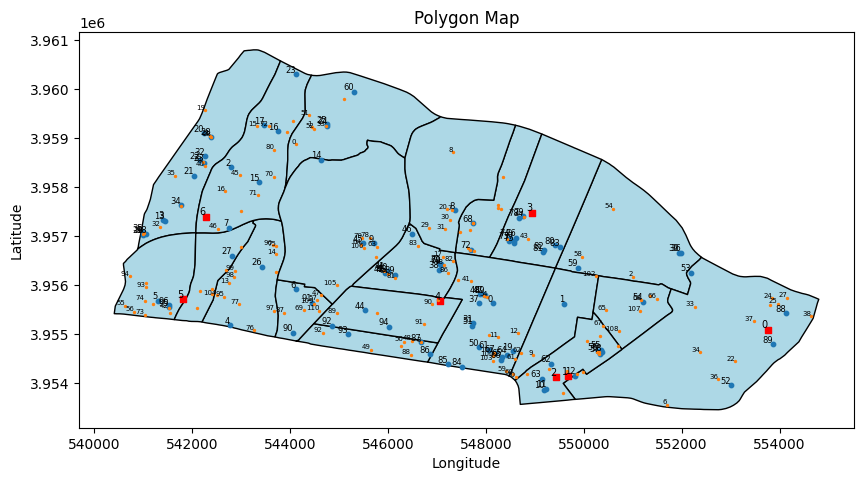

In [ ]:
def BestChromosom_Plot():
    global CMDs_to_LDCs_allocation, LDCs_to_ECs_dist_allocation
    # display shp file
    shapefile_path = "C:\\Users\\Amir\\Desktop\\SDSS-Project\\Data\\Mahallat\\Reg_4.shp"
    polygons = gpd.read_file(shapefile_path)
    # print(polygons.head())
    polygons.plot(edgecolor='black', facecolor='lightblue', figsize=(10, 8))
    plt.title("Polygon Map")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    
    # display nodes
    x_cmd = []
    y_cmd = []
    x_ldc = []
    y_ldc = []
    x_ec = []
    y_ec = []
    for i in CMD_Coordinate:
        x_cmd.append(i[0])
        y_cmd.append(i[1])
    plt.scatter(x_cmd, y_cmd, c='r', s=15, marker='s')
    for n in range(No_CMD):
        plt.text(x_cmd[n], y_cmd[n], n, fontsize=7, ha='right', va='bottom')
    for i in LDC_Coordinate:
        x_ldc.append(i[0])
        y_ldc.append(i[1])
    plt.scatter(x_ldc, y_ldc, s=10)
    for n in range(No_LDC):
        plt.text(x_ldc[n], y_ldc[n], n, fontsize=6, ha='right', va='bottom')
    for i in EC_Coordinate:
        x_ec.append(i[0])
        y_ec.append(i[1])
    plt.scatter(x_ec, y_ec, s=2)
    for n in range(No_EC):
        plt.text(x_ec[n], y_ec[n], n, fontsize=5, ha='right', va='bottom')

    # display allocation nodes
    for kv in zip(CMDs_to_LDCs_allocation.keys(), CMDs_to_LDCs_allocation.values()):
        key = int(kv[0])
        value = kv[1]
        for v in value:
            plt.plot([x_cmd[key], x_ldc[v]], [y_cmd[key], y_ldc[v]], color='blue', linewidth=1)
    for kv in zip(LDCs_to_ECs_dist_allocation.keys(), LDCs_to_ECs_dist_allocation.values()):
        key = int(kv[0])
        value = kv[1]
        for v in value:
            plt.plot([x_ldc[key], x_ec[v]], [y_ldc[key], y_ec[v]], color='red', linewidth=0.3)
BestChromosom_Plot()


In [ ]:
def generate_neighbors(current_solution, moves_iteration):
    neighbors = []
    moves = []  # برای ذخیره حرکت‌ها
    # حرکت نوع 1: جابجایی در بخش اول
    rn1 = rn.sample(range(No_LDC), moves_iteration)
    rn2 = rn.sample(range(No_LDC), moves_iteration)
    for i in range(moves_iteration):
        neighbor = copy.deepcopy(current_solution)
        neighbor[rn1[i]], neighbor[rn2[i]] = neighbor[rn2[i]], neighbor[rn1[i]]
        neighbors.append(neighbor)
        moves.append(("par1_swap", i, rn2[i]))
    # حرکت نوع 2: جابجایی در بخش اول
    rn1 = rn.sample(range(No_LDC, len(current_solution[No_LDC:])), moves_iteration)
    rn2 = rn.sample(range(No_LDC, len(current_solution[No_LDC:])), moves_iteration)
    for _ in range(moves_iteration):
        neighbor = copy.deepcopy(current_solution)
        neighbor[rn1[i]], neighbor[rn2[i]] = neighbor[rn2[i]], neighbor[rn1[i]]
        neighbors.append(neighbor)
        moves.append(("par2_swap", rn1[i], rn2[i]))
    # حرکت نوع 3: افزودن یا حذف LDC
    Commo_random_values = truncnorm.rvs(a_std, b_std, loc=mu*2, scale=std, size=moves_iteration)
    for i in range(moves_iteration):
        k = rn.choice(range(No_LDC))
        if current_solution[k] == 0:
            neighbor = copy.deepcopy(current_solution)
            neighbor[k] = [rn.choice(cmd_allowed_numbers), Commo_random_values[i] if Commo_random_values[i] > V else V]
            neighbors.append(neighbor)
            moves.append(("ChangeLDC", k, neighbor[k]))
        else:
            neighbor = copy.deepcopy(current_solution)
            neighbor[k] = 0
            neighbors.append(neighbor)
            moves.append(("ChangeLDC", k, 0))

    return neighbors, moves

def tabu_search(initial_solution, max_iterations, tabu_tenure):
    current_solution = initial_solution
    best_solution = copy.deepcopy(current_solution)
    best_cost = fitness([best_solution])

    tabu_list = []  # لیست ممنوعه برای ذخیره حرکت‌ها
    bc = []
    for m in range(max_iterations):
        # print(m)
        neighbors, moves = generate_neighbors(current_solution, 50)

        # فیلتر کردن همسایه‌های مجاز
        valid_neighbors = []
        valid_moves = []
        for neighbor, move in zip(neighbors, moves):
            if move not in tabu_list:
                valid_neighbors.append(neighbor)
                valid_moves.append(move)

        if not valid_neighbors:
            break  # هیچ همسایه مجازی وجود ندارد

        # ارزیابی همسایه‌ها
        neighbors_costs = [fitness([n]) for n in valid_neighbors]
        min_cost = min(neighbors_costs)
        min_index = neighbors_costs.index(min_cost)

        # به‌روزرسانی جواب فعلی
        current_solution = valid_neighbors[min_index]
        current_move = valid_moves[min_index]

        # به‌روزرسانی بهترین جواب
        if min_cost < best_cost:
            best_solution = copy.deepcopy(current_solution)
            best_cost = min_cost
        bc.append(best_cost)
        
        # به‌روزرسانی لیست ممنوعه
        tabu_list.append(current_move)
        if len(tabu_list) > tabu_tenure:
            tabu_list.pop(0)
            
    plt.plot(range(1,max_iterations+1),bc)
    plt.title(f'min_fitness = {best_cost}')
    plt.show()

    return best_solution, best_cost
tabu_best_solution = tabu_search(genetic_best_solution, 100, 3)
fitness([tabu_best_solution[0]])
print("Best Solution = ", tabu_best_solution)
print(f"Unmet Demand = {unmet_demand}\nAdditional Inventory = {additional_inventory}\nSum Distance = {sum_dist}\nSum Opened LDC = {sum_opened_LDC}")


sum_dist: 995209.0106217648
sum_opened_LDC: 54
unmet_demand: 8010.2921593869105
additional_inventory: 0

sum_dist: 1044449.1906238911
sum_opened_LDC: 54
unmet_demand: 8010.2921593869105
additional_inventory: 0

sum_dist: 1022633.4782145984
sum_opened_LDC: 54
unmet_demand: 8010.2921593869105
additional_inventory: 0

sum_dist: 1007469.4493565127
sum_opened_LDC: 54
unmet_demand: 8010.2921593869105
additional_inventory: 0

sum_dist: 1013657.8951398884
sum_opened_LDC: 54
unmet_demand: 8010.292159387376
additional_inventory: 0

sum_dist: 997261.5245436352
sum_opened_LDC: 54
unmet_demand: 8010.2921593869105
additional_inventory: 0

sum_dist: 994440.2724212091
sum_opened_LDC: 54
unmet_demand: 8010.2921593869105
additional_inventory: 0

sum_dist: 995771.3804314864
sum_opened_LDC: 54
unmet_demand: 8010.2921593869105
additional_inventory: 0

sum_dist: 1015793.6385154073
sum_opened_LDC: 54
unmet_demand: 8010.2921593869105
additional_inventory: 0

sum_dist: 1020494.7991378948
sum_opened_LDC: 54
un

KeyboardInterrupt: 

In [ ]:
LDCs_to_ECs_dist_allocation

{'0': [90, 105],
 '1': [],
 '2': [156, 131, 157],
 '3': [15, 62, 45],
 '4': [],
 '5': [],
 '6': [89],
 '7': [],
 '8': [],
 '9': [78, 34, 144],
 '10': [147, 55, 99],
 '11': [126, 96],
 '12': [129, 26, 141],
 '13': [32, 46, 69],
 '14': [],
 '15': [75, 104, 77],
 '16': [],
 '17': [],
 '18': [94, 0, 143],
 '19': [146],
 '20': [19, 112, 81],
 '21': [42, 145, 137],
 '22': [138, 53, 33],
 '23': [72, 142, 95],
 '24': [1, 139, 24],
 '25': [52, 23, 4],
 '26': [57, 71, 135],
 '27': [98, 74, 10],
 '28': [21, 149, 89],
 '29': [102],
 '30': [14, 152, 146],
 '31': [],
 '32': [153, 116, 102],
 '33': [],
 '34': [39, 121, 41],
 '35': [54, 63, 58],
 '36': [5, 20, 128],
 '37': [86, 11, 105],
 '38': [47, 106, 96],
 '39': [79, 43],
 '40': [85, 51],
 '41': [],
 '42': [64, 67],
 '43': [],
 '44': [],
 '45': [7, 91],
 '46': [41],
 '47': [115, 108],
 '48': [],
 '49': [61, 59],
 '50': [150, 68],
 '51': [],
 '52': [],
 '53': [136, 66],
 '54': [133, 127],
 '55': [134, 22],
 '56': [2, 130],
 '57': [118, 9],
 '58': [

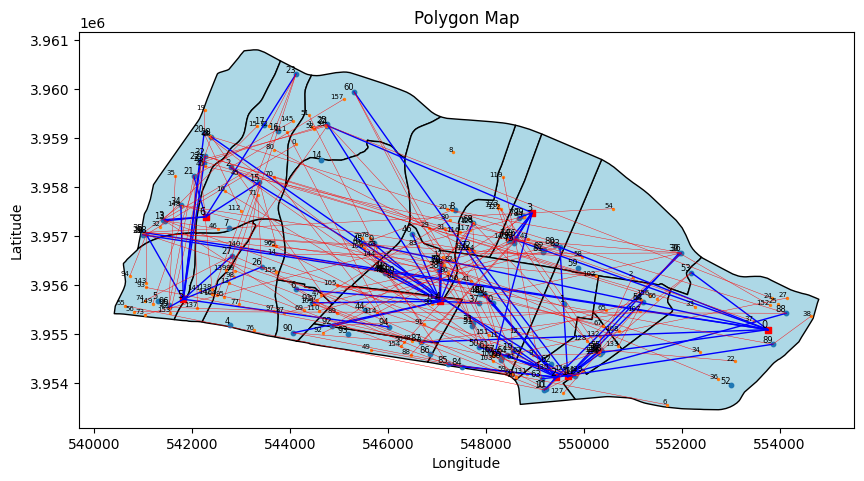

In [ ]:
BestChromosom_Plot()